In [35]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import pywt
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string
import matplotlib.pyplot as plt

In [36]:
# Helper function for D-Markov Machine state construction
def construct_d_markov_states(data, alphabet_size, D):
    """
    Constructs states for the D-Markov Machine and returns the transition matrix and state index mapping.
    Args:
        data: The input symbolic time series data.
        alphabet_size: Size of the symbol alphabet.
        D: The order of the Markov machine.
    Returns:
        transition_matrix: Transition matrix of size (n_states, n_states).
        state_index: Dictionary mapping states to their indices.
    """
    states = {}

    # Generate states for the D-Markov Machine
    for i in range(len(data) - D):
        state = tuple(data[i:i + D])
        next_symbol = data[i + D]
        if state not in states:
            states[state] = np.zeros(alphabet_size)
        states[state][next_symbol] += 1

    # Create a mapping of states to indices
    all_states = list(states.keys())
    state_index = {state: idx for idx, state in enumerate(all_states)}
    n_states = len(all_states)

    # Construct the transition matrix
    transition_matrix = np.zeros((n_states, n_states))
    for state, transitions in states.items():
        row_idx = state_index[state]
        for next_symbol, prob in enumerate(transitions):
            next_state = tuple(list(state[1:]) + [next_symbol])
            if next_state in state_index:
                col_idx = state_index[next_state]
                transition_matrix[row_idx, col_idx] = prob / np.sum(transitions)

    return transition_matrix, state_index




# Helper function to compute the stationary probability vector
def compute_stationary_vector(transition_matrix):
    """
    Compute the stationary probability vector for a D-Markov Machine.
    Args:
        transition_matrix: Transition matrix of the D-Markov Machine.
    Returns:
        stationary_vector: The stationary probability vector.
    """
    eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
    stationary_vector = eigvecs[:, np.isclose(eigvals, 1, atol=1e-6)].flatten().real
    stationary_vector /= np.sum(stationary_vector)  # Normalize

    return stationary_vector



# Implement the D-Markov Machine for SFNN and WS
def d_markov_anomaly_measure(symbolic_data, reference_data, alphabet_size, D):
    """
    Calculate the anomaly measure using the D-Markov Machine.
    Args:
        symbolic_data: Symbolic sequence for the test condition.
        reference_data: Symbolic sequence for the nominal condition.
        alphabet_size: Size of the symbol alphabet.
        D: Order of the Markov machine.
    Returns:
        anomaly_measure: Anomaly measure based on stationary probability vector.
    """
    reference_matrix, reference_index = construct_d_markov_states(reference_data, alphabet_size, D)
    test_matrix, test_index = construct_d_markov_states(symbolic_data, alphabet_size, D)

    # Ensure state indices align
    all_states = sorted(set(reference_index.keys()).union(test_index.keys()))
    ref_aligned = np.zeros((len(all_states), len(all_states)))
    test_aligned = np.zeros((len(all_states), len(all_states)))

    for state in all_states:
        if state in reference_index:
            ref_row = reference_matrix[reference_index[state], :]
            for next_state in all_states:
                if next_state in reference_index:
                    ref_aligned[all_states.index(state), all_states.index(next_state)] = ref_row[reference_index[next_state]]

        if state in test_index:
            test_row = test_matrix[test_index[state], :]
            for next_state in all_states:
                if next_state in test_index:
                    test_aligned[all_states.index(state), all_states.index(next_state)] = test_row[test_index[next_state]]

    # Normalize rows to ensure they sum to 1
    ref_aligned = np.nan_to_num(ref_aligned)
    row_sums = ref_aligned.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero for empty rows
    ref_aligned /= row_sums

    test_aligned = np.nan_to_num(test_aligned)
    row_sums = test_aligned.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero for empty rows
    test_aligned /= row_sums

    # Compute stationary probability vectors
    p_nom = compute_stationary_vector(ref_aligned)
    p_test = compute_stationary_vector(test_aligned)

    # Calculate anomaly measure based on the KL divergence
    kl_divergence = np.sum(p_nom * np.log((p_nom + 1e-8) / (p_test + 1e-8)))

    return kl_divergence






In [37]:
# Simulate the nonlinear electronic system based on the Duffing equation
def generate_time_series(beta_values, A, omega, sampling_rate, total_time):
    """
    Generate synthetic time series data based on the Duffing oscillator.
    Args:
        beta_values: List of dissipation parameter values (beta).
        A: Amplitude of the driving force.
        omega: Frequency of the driving force.
        sampling_rate: Sampling rate for time series generation.
        total_time: Total duration of the time series.
    Returns:
        time_series_data: Dictionary mapping beta values to corresponding time series.
    """
    time = np.arange(0, total_time, 1 / sampling_rate)
    time_series_data = {}

    for beta in beta_values:
        y = np.zeros(len(time))
        dy_dt = np.zeros(len(time))
        
        for i in range(1, len(time)):
            d2y_dt2 = -beta * dy_dt[i - 1] - y[i - 1] - y[i - 1]**3 + A * np.cos(omega * time[i])
            dy_dt[i] = dy_dt[i - 1] + d2y_dt2 * (1 / sampling_rate)
            y[i] = y[i - 1] + dy_dt[i] * (1 / sampling_rate)

        time_series_data[beta] = y

    return time_series_data




In [38]:
# Configuration for the experiments
beta_values = np.linspace(0.10, 0.35, 20)  # Beta values for experiments
A = 22.0  # Driving amplitude
omega = 5.0  # Driving frequency
sampling_rate = 100  # Hz
total_time = 40  # Seconds (extended for 2700 samples)

In [39]:
# Generate time series data
time_series_data = generate_time_series(beta_values, A, omega, sampling_rate, total_time)

# Preprocess the data
scaler = StandardScaler()
data_scaled = {beta: scaler.fit_transform(time_series.reshape(-1, 1)).flatten() 
               for beta, time_series in time_series_data.items()}

# Reshape data into a matrix with 270 segments of length 10
def reshape_to_segments(data, segment_length=10):
    num_segments = len(data) // segment_length
    return data[:num_segments * segment_length].reshape((num_segments, segment_length))

segmented_data = {beta: reshape_to_segments(data, segment_length=10) 
                  for beta, data in data_scaled.items()}

In [40]:
data_scaled.keys()

dict_keys([0.1, 0.11315789473684211, 0.12631578947368421, 0.1394736842105263, 0.15263157894736842, 0.16578947368421054, 0.17894736842105263, 0.19210526315789472, 0.20526315789473684, 0.21842105263157896, 0.23157894736842105, 0.24473684210526317, 0.2578947368421053, 0.2710526315789473, 0.28421052631578947, 0.2973684210526316, 0.31052631578947365, 0.3236842105263158, 0.3368421052631579, 0.35])

C:\Users\ibrah\AppData\Local\Temp\ipykernel_4432\2776904039.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


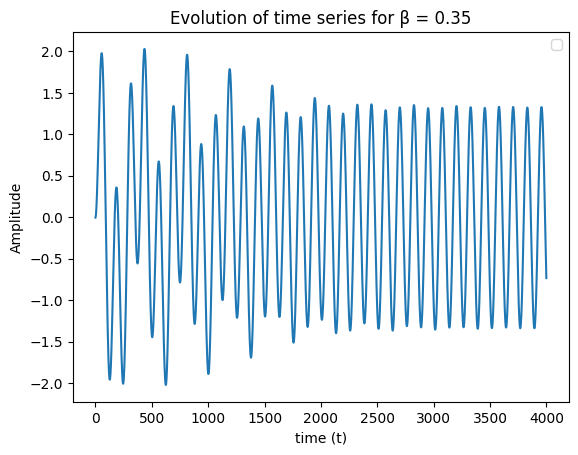

In [41]:
plt.plot(data_scaled[0.35])
plt.xlabel('time (t)')
plt.ylabel('Amplitude')
plt.title('Evolution of time series for β = 0.35')
plt.legend()
plt.savefig('hhh.png', dpi=300, bbox_inches='tight')

In [42]:
# Apply PCA to segmented data
pca_results = {}
for beta, segments in segmented_data.items():
    pca = PCA(n_components=2)  # Assuming at least 2 features in reshaped data
    pca_results[beta] = pca.fit_transform(segments)

# Use PCA results for anomaly detection
pca_anomaly_measures = {}
for beta, transformed_segments in pca_results.items():
    nominal_transformed = pca_results[0.10]  # Nominal beta transformed segments
    mse = mean_squared_error(nominal_transformed.flatten(), transformed_segments.flatten())
    pca_anomaly_measures[beta] = mse

# Normalize PCA anomaly measures
pca_anomaly_measures = {beta: value - pca_anomaly_measures[0.10] for beta, value in pca_anomaly_measures.items()}
max_pca = max(pca_anomaly_measures.values())
pca_anomaly_measures = {beta: value / max_pca for beta, value in pca_anomaly_measures.items()}

In [43]:
# Train MLP on nominal condition (beta = 0.10)
nominal_beta = 0.10
nominal_segments = segmented_data[nominal_beta]
X_nom = nominal_segments
y_nom = np.mean(nominal_segments, axis=1)  # Target can be adjusted based on context

mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 40), max_iter=1000, tol=1e-5, 
                    activation='tanh', random_state=42)
mlp.fit(X_nom, y_nom)

# Evaluate anomaly measures for MLP
mlp_anomaly_measures = {}
for beta, segments in segmented_data.items():
    X = segments
    y = np.mean(segments, axis=1)
    predictions = mlp.predict(X)
    mse = mean_squared_error(y, predictions)
    mlp_anomaly_measures[beta] = mse

# Normalize MLP anomaly measures
mlp_anomaly_measures = {beta: value - mlp_anomaly_measures[0.10] for beta, value in mlp_anomaly_measures.items()}
max_mlp = max(mlp_anomaly_measures.values())
mlp_anomaly_measures = {beta: value / max_mlp for beta, value in mlp_anomaly_measures.items()}

In [44]:
# Implement RBFNN for anomaly detection
kernel = RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr.fit(X_nom, y_nom)

rbf_anomaly_measures = {}
for beta, segments in segmented_data.items():
    X = segments
    y = np.mean(segments, axis=1)
    predictions, _ = gpr.predict(X, return_std=True)
    mse = mean_squared_error(y, predictions)
    rbf_anomaly_measures[beta] = mse

# Normalize RBF anomaly measures
rbf_anomaly_measures = {beta: value - rbf_anomaly_measures[0.10] for beta, value in rbf_anomaly_measures.items()}
max_rbf = max(rbf_anomaly_measures.values())
rbf_anomaly_measures = {beta: value / max_rbf for beta, value in rbf_anomaly_measures.items()}

In [45]:
# SFNN Method
def symbolic_false_nearest_neighbors(data, alphabet_size):
    """Apply SFNN for partitioning time series into symbolic sequences."""
    bins = np.linspace(np.min(data), np.max(data)+1e-6, alphabet_size + 1)
    symbolic_sequence = np.digitize(data, bins) - 1
    return symbolic_sequence

# Wavelet Space Method with SAX symbolization
def wavelet_space_partitioning_sax(data, wavelet='db1', alphabet_size=8):
    """Partition the data in wavelet space using SAX symbolization."""
    # Perform the wavelet decomposition at specified scale levels
    coeffs = pywt.wavedec(data, wavelet, level=1)  # Fixed level=1 as described in the paper
    
    # Flatten the wavelet coefficients
    flattened_coeffs = np.concatenate(coeffs)

    # Standardize the coefficients to have zero mean and unit variance
    standardized_coeffs = (flattened_coeffs - np.mean(flattened_coeffs)) / np.std(flattened_coeffs)

    # Generate SAX cuts for the specified alphabet size
    sax_cuts = cuts_for_asize(alphabet_size)

    # Apply SAX symbolization
    sax_symbols = ts_to_string(standardized_coeffs, sax_cuts)

    return np.array([ord(symbol) - ord('a') for symbol in sax_symbols])



sfnn_anomaly_measures = {}
ws_anomaly_measures = {}
D = 1  # Order of the Markov machine
alphabet_size = 8
nominal_beta = 0.10 

for beta, data in data_scaled.items():
    # SFNN Symbolization
    symbolic_sfnn = symbolic_false_nearest_neighbors(data, alphabet_size=alphabet_size)
    nominal_sfnn = symbolic_false_nearest_neighbors(data_scaled[nominal_beta], alphabet_size=alphabet_size)

    # WS Symbolization
    symbolic_ws = wavelet_space_partitioning_sax(data, wavelet='db1', alphabet_size=alphabet_size)
    nominal_ws = wavelet_space_partitioning_sax(data_scaled[nominal_beta], wavelet='db1', alphabet_size=alphabet_size)

    # SFNN D-Markov Anomaly Measure
    sfnn_anomaly_measures[beta] = d_markov_anomaly_measure(symbolic_sfnn, nominal_sfnn, alphabet_size, D)

    # WS D-Markov Anomaly Measure
    ws_anomaly_measures[beta] = d_markov_anomaly_measure(symbolic_ws, nominal_ws, alphabet_size, D)

# Normalize SFNN and WS measures
sfnn_anomaly_measures = {beta: value - sfnn_anomaly_measures[0.10] for beta, value in sfnn_anomaly_measures.items()}
max_sfnn = max(sfnn_anomaly_measures.values())
sfnn_anomaly_measures = {beta: value / max_sfnn for beta, value in sfnn_anomaly_measures.items()}

ws_anomaly_measures = {beta: value - ws_anomaly_measures[0.10] for beta, value in ws_anomaly_measures.items()}
max_ws = max(ws_anomaly_measures.values())
ws_anomaly_measures = {beta: value / max_ws for beta, value in ws_anomaly_measures.items()}



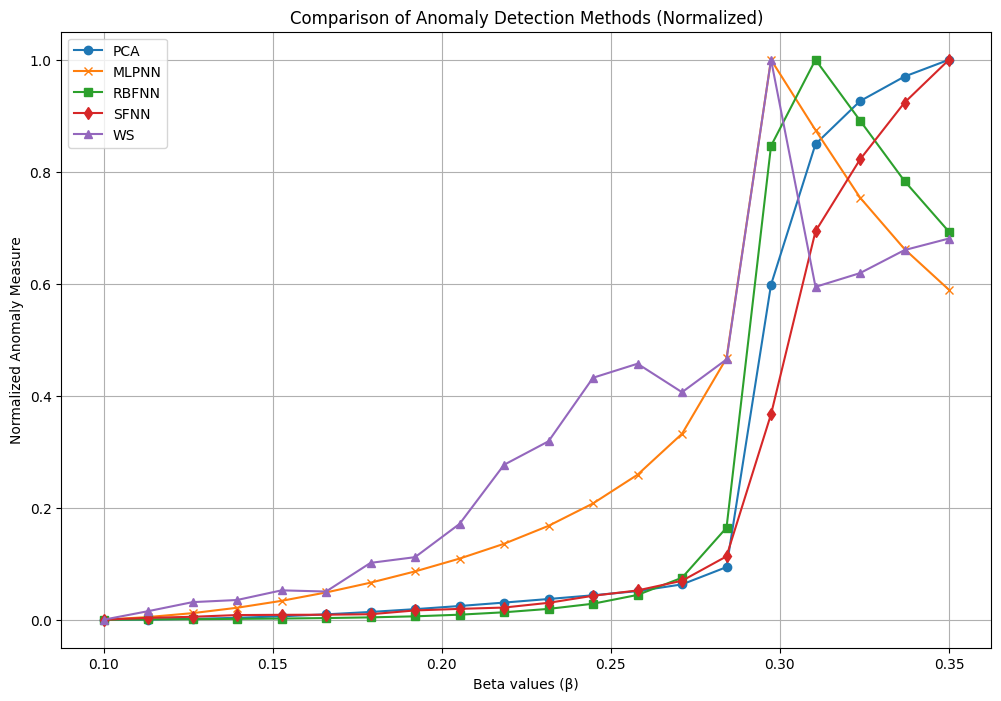

In [46]:
# Plot all anomaly measures
plt.figure(figsize=(12, 8))
plt.plot(list(pca_anomaly_measures.keys()), list(pca_anomaly_measures.values()), marker='o', label='PCA')
plt.plot(list(mlp_anomaly_measures.keys()), list(mlp_anomaly_measures.values()), marker='x', label='MLPNN')
plt.plot(list(rbf_anomaly_measures.keys()), list(rbf_anomaly_measures.values()), marker='s', label='RBFNN')
plt.plot(list(sfnn_anomaly_measures.keys()), list(sfnn_anomaly_measures.values()), marker='d', label='SFNN')
plt.plot(list(ws_anomaly_measures.keys()), list(ws_anomaly_measures.values()), marker='^', label='WS')
plt.xlabel('Beta values (β)')
plt.ylabel('Normalized Anomaly Measure')
plt.title('Comparison of Anomaly Detection Methods (Normalized)')
plt.grid()
plt.legend()
plt.savefig('hhh.png', dpi=300, bbox_inches='tight')
plt.show()